## Part 1: Pulse Rate Algorithm - Experiment 1

In this experiment we show that even a simple algorithm that consistently picks the PPG spectrum with the highest magnitude.

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.stats
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("../lib")
import troika
import mpld3

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    pbar = tqdm(list(zip(data_fls, ref_fls)))
    for data_fl, ref_fl in pbar:
        pbar.set_description("{} and {}".format(data_fl.split('/')[-1], ref_fl.split('/')[-1]))
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
#         break
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

# Copy all stuff below to the test app.
    
class Log():
    temp = {}
    
    def __init__(self):
        pass
    
    def prepare(self, **kwargs):
        for key in kwargs:
            self.temp[key] = kwargs[key]
    
    def commit(self):
        for key in self.temp: 
            setattr(self, key, self.temp[key])
    
log = Log()

FS = 125
WINDOW_LEN_S = 8
PAST_WINDOW = 3
MULTIPLIER = 4


def RunPulseRateAlgorithm(data_fl, ref_fl, log_vars=True):
    """ Running Pulse Rate Algorithm
    """
    
    # Frequency of the signals sampled in Hertz.
    # For example, 125 means there are 125 samples every second.
    fs = FS # Hertz
    
    # Each reference pulse rate is calculated from this many seconds.
    window_len_s = WINDOW_LEN_S # seconds
    
    # Time difference (in seconds) between one time window and the next.
    window_shift_s = 2 # seconds
    
    # Pulse rate restrictions
    rest_min_fs = 1 / 40 / 60.0
    rest_max_fs = 1 / 240 / 60.0
    
    pass_band = (40/60.0, 240/60.0)
    
    # Load data using scipy. "scipy.io.loadmat(f)"
    sigs = scipy.io.loadmat(data_fl)['sig']
    refs = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    
    errors = []
    confidence = []
    estimations = []
    
    largest_error = None
    
    start_idxs, end_idxs = troika.get_idxs(sigs.shape[1], len(refs), fs, window_len_s, window_shift_s)
    for i, start_idx in enumerate(start_idxs):
        end_idx = end_idxs[i]
        
        # ECG-related
        ecg = sigs[0, start_idx:end_idx]
        ref = refs[i]
        
        # Start working on the signals below
        ppg = np.mean(sigs[1:3, start_idx: end_idx], axis=0)
        accx = sigs[3, start_idx:end_idx]
        accy = sigs[4, start_idx:end_idx]
        accz = sigs[5, start_idx:end_idx]
        
        if log_vars:
            ppg1 = sigs[1, start_idx:end_idx]
            ppg2 = sigs[2, start_idx:end_idx]
            log.prepare(ppg1=ppg1, ppg2=ppg2, ppg=ppg,
                        accx=accx, accy=accy, accz=accz,
                        ref=ref, ecg=ecg, fl=data_fl, i=i)
        
        # Bandpass Filter
        ppg = troika.bandpass_filter(ppg, pass_band, fs)
        accx = troika.bandpass_filter(accx, pass_band, fs)
        accy = troika.bandpass_filter(accy, pass_band, fs)
        accz = troika.bandpass_filter(accz, pass_band, fs)
        
        if log_vars:
            log.prepare(ppg1_bp=ppg1, ppg2_bp=ppg2, ppg_bp=ppg,
                        accx_bp=accx, accy_bp=accy, accz_bp=accz)
        
        # Get PPG power spectrums
        n = len(ppg) * MULTIPLIER
        freqs = np.fft.rfftfreq(n, 1/fs)
        fft = np.abs(np.fft.rfft(ppg, n))
        fft[freqs <= pass_band[0]] = 0.0
        fft[freqs >= pass_band[1]] = 0.0

        # Get max magnitude's frequency as the estimation
        est_fs = freqs[np.argmax(fft)]
        
        fs_window = 5 / 60.0
        est_fs_window = (freqs >= est_fs - fs_window) & (freqs <= est_fs + fs_window)
        conf = np.sum(fft[est_fs_window]) / np.sum(fft)

        error = np.abs(est_fs * 60 - ref)
        
        if log_vars and (largest_error is None or error > largest_error):
#         if log_vars and (i == 0 and 'DATA_12_TYPE02' in data_fl):
            log.prepare(ppg_fft_window=ppg_fft_window, acc_fft_window=acc_fft_window)
            log.commit()
            
            largest_error = error
        
        errors.append(error)
        confidence.append(conf)
        estimations.append(est_fs * 60)
    
#     print(np.array(errors).shape)
#     print(estimations)
#     print(refs)
#     print(errors)
#     print(confidence)

#     raise Exception
    return np.array(errors), np.array(confidence)

Evaluate()

13.364892800506752

In [2]:
def plot_freq(ax_freq, freqs, fft, fs, target_hz, title='None', freq_xlim=(0.4, 5)):
    ax_freq.plot(freqs, fft, 'bo-')
    ax_freq.plot([target_hz, target_hz], [0, max(fft)], 'r')
    ax_freq.set_title(title)
    ax_freq.set_xlabel('Frequency (Hz)')
    ax_freq.set_ylabel('Magnitude')
    ax_freq.set_xlim(freq_xlim)

    
def plot_time_freq(ax_time, ax_freq, data, fs, target_hz,
                   title='Plot', freq_xlim=(0.4, 5), pass_band=None, multiplier=2):
    ax_time.plot(data)
    ax_time.set_title(title)
    ax_time.set_ylabel('Magnitude')

    n = len(data) * multiplier
    freqs = np.fft.rfftfreq(n, 1/fs)
    fft = np.abs(np.fft.rfft(data, n))
    
    if pass_band is not None:
        fft[freqs <= pass_band[0]] = 0.0
        fft[freqs >= pass_band[1]] = 0.0
    
    plot_freq(ax_freq, freqs, fft, fs, target_hz,
              title="{} - Frequency Domain".format(title), freq_xlim=freq_xlim)

## Frequency Domain of the largest error

In this part, we analyze the frequency domain for the largest error.

File: ./datasets/troika/training_data/DATA_12_TYPE02.mat
i: 81
Ground Truth: 158.7302 BPM or 2.645503333333333 Hz
Freq with highest magnitude: 76.875 BPM or 1.28125 Hz
diff: 1.364253333333333
Confidence: 0.13702049731790203


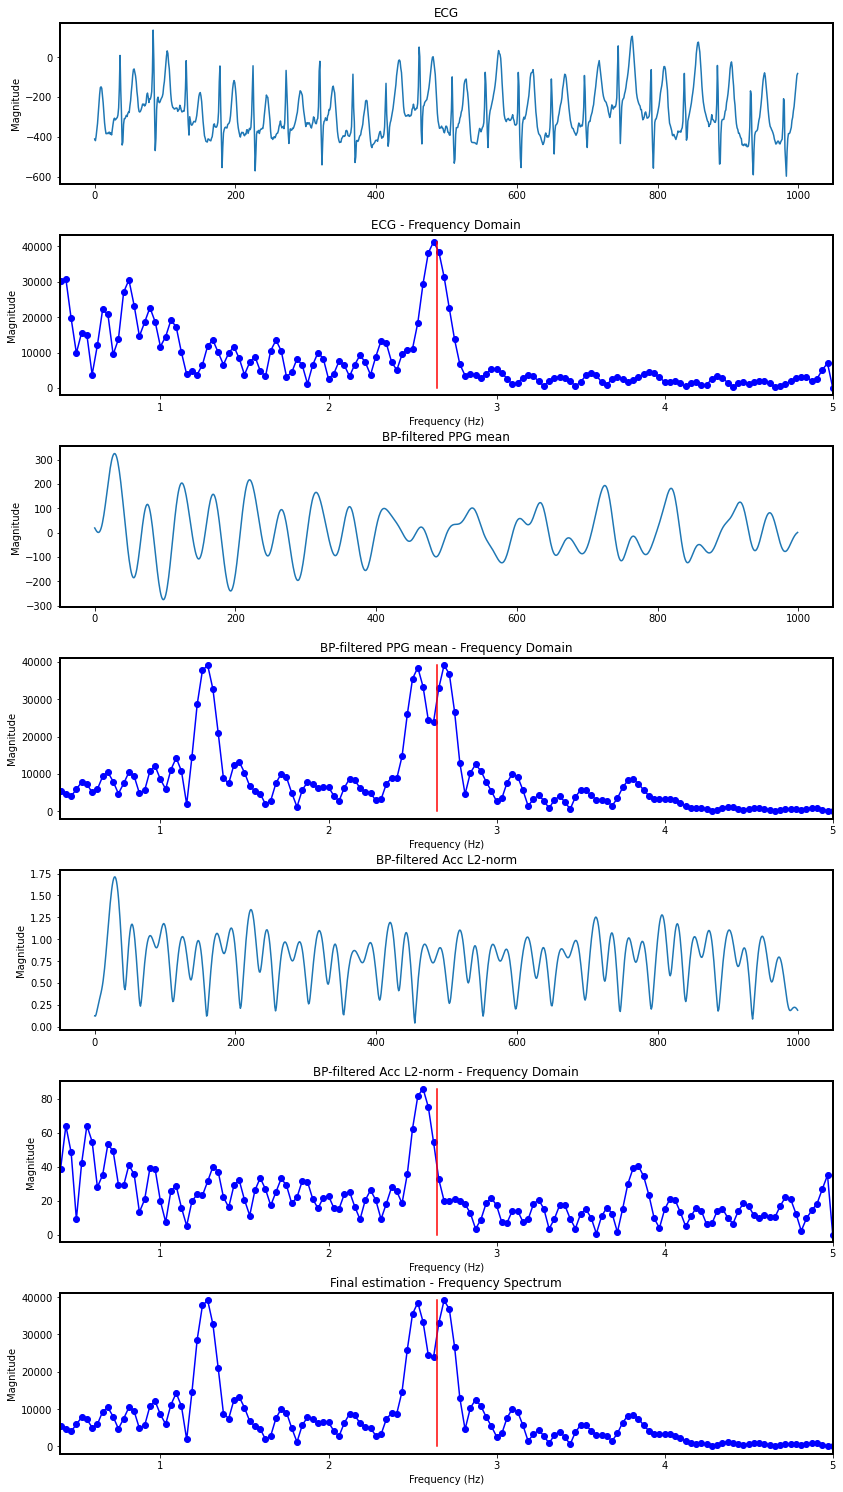

In [3]:
mpld3.enable_notebook()
fs = 125

print("File: {}\ni: {}".format(log.fl, log.i))

ref_hz = log.ref / 60.0
print("Ground Truth: {} BPM or {} Hz".format(log.ref, ref_hz))
pass_band = (0.4, 5.0)
ecg = log.ecg
ppg1 = log.ppg1
ppg2 = log.ppg2
ppg1_bp = log.ppg1_bp
ppg2_bp = log.ppg2_bp
ppg = log.ppg
ppg_bp = log.ppg_bp
ppg_fft_window = log.ppg_fft_window
acc_fft_window = log.acc_fft_window
accx = log.accx
accy = log.accy
accz = log.accz
accx_bp = log.accx_bp
accy_bp = log.accy_bp
accz_bp = log.accz_bp

numplots = 7
ax = [None] * numplots
fig, ax = plt.subplots(nrows=numplots, figsize=(12,numplots * 3))
fig.tight_layout(pad=3.0)

# Get PPG power spectrums
n = len(ppg_bp) * MULTIPLIER
freqs = np.fft.rfftfreq(n, 1/fs)
fft = np.abs(np.fft.rfft(ppg_bp, n))
fft[freqs <= pass_band[0]] = 0.0
fft[freqs >= pass_band[1]] = 0.0

# # Insert and roll
# ppg_fft_window[0,:] = fft
# ppg_fft_window = np.roll(ppg_fft_window, -1, axis=0)
# fft = np.nanmean(ppg_fft_window, axis=0)

# Get L2-norms of accelerations
acc_l2 = np.sqrt(accx_bp ** 2 + accy_bp ** 2 + accz_bp ** 2)

# Get acceleration power spectrums
acc_freqs = np.fft.rfftfreq(n, 1/fs)
acc_fft = np.abs(np.fft.rfft(acc_l2, n))
acc_fft[acc_freqs <= pass_band[0]] = 0.0
acc_fft[acc_freqs >= pass_band[1]] = 0.0

# # Insert and roll
# acc_fft_window[0,:] = acc_fft
# acc_fft_window = np.roll(acc_fft_window, -1, axis=0)
# acc_fft = np.nanmean(acc_fft_window, axis=0)

# Reduce PPG's magnitudes with those of acceleration's
# fft[acc_fft > 0.5 * np.max(acc_fft)] = 0
# fft = fft / l2_fft
# fft = np.nan_to_num(fft)
# print(fft)
# acc_fft[acc_fft == 0] = 1
# fft = fft / np.nan_to_num(acc_fft, nan=1)

est_fs = freqs[np.argmax(fft)]

plot_time_freq(ax[0], ax[1], ecg, fs, ref_hz, title="ECG", pass_band=pass_band, multiplier=MULTIPLIER)
plot_time_freq(ax[2], ax[3], ppg_bp, fs, ref_hz, title="BP-filtered PPG mean", pass_band=pass_band, multiplier=MULTIPLIER)
plot_time_freq(ax[4], ax[5], acc_l2, fs, ref_hz, title="BP-filtered Acc L2-norm", pass_band=pass_band, multiplier=MULTIPLIER)
plot_freq(ax[6], freqs, fft, fs, ref_hz, title="Final estimation - Frequency Spectrum")

print("Freq with highest magnitude: {} BPM or {} Hz".format(est_fs * 60, est_fs))
print("diff: {}".format(np.abs(est_fs - ref_hz)))

fs_window = 5 / 60.0
est_fs_window = (freqs >= est_fs - fs_window) & (freqs <= est_fs + fs_window)
conf = np.sum(fft[est_fs_window]) / np.nansum(fft)
print("Confidence: {}".format(conf))


## SSR

Development of SSR process with a single window.

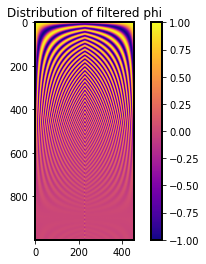

In [4]:
mpld3.disable_notebook()

def SSR(y, fs=125, M=1000, N=64**2, pass_band=(0.4, 5.0), noise=0.1, g_p=0.8, max_iter=5, random_seed=13):
    """ Get SSR spectrum from a given data
    """

    def get_prune_limits(phi, N, fs, pass_band):
        low_band = pass_band[0]
        high_band = pass_band[1]
        delta_f1 = low_band / float(fs) * N - 1
        delta_f2 = 2 / float(fs) * N

        f1_l1 = low_band / float(fs) * N + 1 - delta_f1
        f1_l2 = high_band / float(fs) * N + 1 + delta_f2
        f2_l1 = N - high_band / fs * N + 1 - delta_f2
        f2_l2 = N - low_band / fs * N + 1 + delta_f1
        return (int(f1_l1), int(f1_l2), int(f2_l1), int(f2_l2))


    mtx_M = np.linspace(0, M-1, M).reshape(M, 1)
    mtx_N = np.linspace(0, N-1, N).reshape(1, N)
    mtx_MN = mtx_M.dot(mtx_N)

    phi = np.exp(1j * 2*(np.pi/N) * mtx_MN)
    f1_l1, f1_l2, f2_l1, f2_l2 = get_prune_limits(phi, N, fs, pass_band)

    phi = phi[:, np.r_[f1_l1:f1_l2, f2_l1:f2_l2]]
    phi = np.real(phi)

    # Plot
    plt.imshow(np.real(phi))
    plt.colorbar();
    plt.title("Distribution of filtered phi")

    def g(x):
        return np.linalg.norm(x, ord=g_p)

    def objective(x, y, phi, noise):
        return np.linalg.norm(y-(phi.dot(x)), ord=2)**2 + noise * g(x)

    np.random.seed(random_seed)
    x0 = np.random.randn(N)
    x0 = x0[np.r_[f1_l1:f1_l2, f2_l1:f2_l2]]

    output = scipy.optimize.minimize(objective, x0,
                                     options={'maxiter': max_iter},
                                     args=(y, phi, noise))
    return output

output = SSR(acc_l2,
             fs=125,
             M=8 * fs,
             N=64**2,
             pass_band=pass_band)

This is how a correct `x_hat` value distribution looks like:

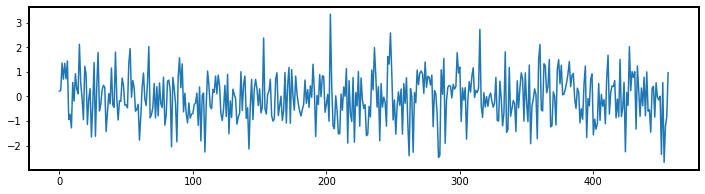

In [5]:
mpld3.enable_notebook()
plt.figure(figsize=(12, 3))
plt.plot(output.x);

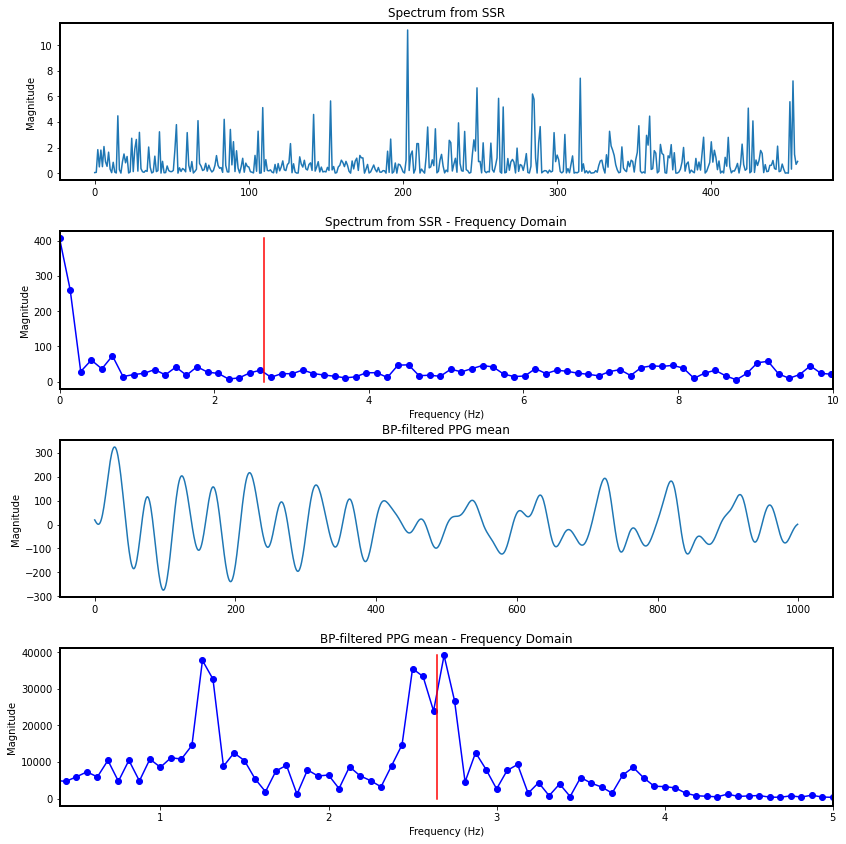

In [6]:
mpld3.enable_notebook()

# Get spectrum
s = output.x**2


numplots = 4
ax = [None] * numplots
fig, ax = plt.subplots(nrows=numplots, figsize=(12,numplots * 3))
fig.tight_layout(pad=3.0)

plot_time_freq(ax[0], ax[1], s, fs, ref_hz, title='Spectrum from SSR', freq_xlim=(0, 10))
plot_time_freq(ax[2], ax[3], ppg_bp, fs, ref_hz, title="BP-filtered PPG mean")

## Spectral Peak-Tracking



## Bandpass-filtered Distributions

Ground Truth: 158.7302 BPM == 2.645503333333333 Hz


ValueError: operands could not be broadcast together with shapes (2001,) (501,) 

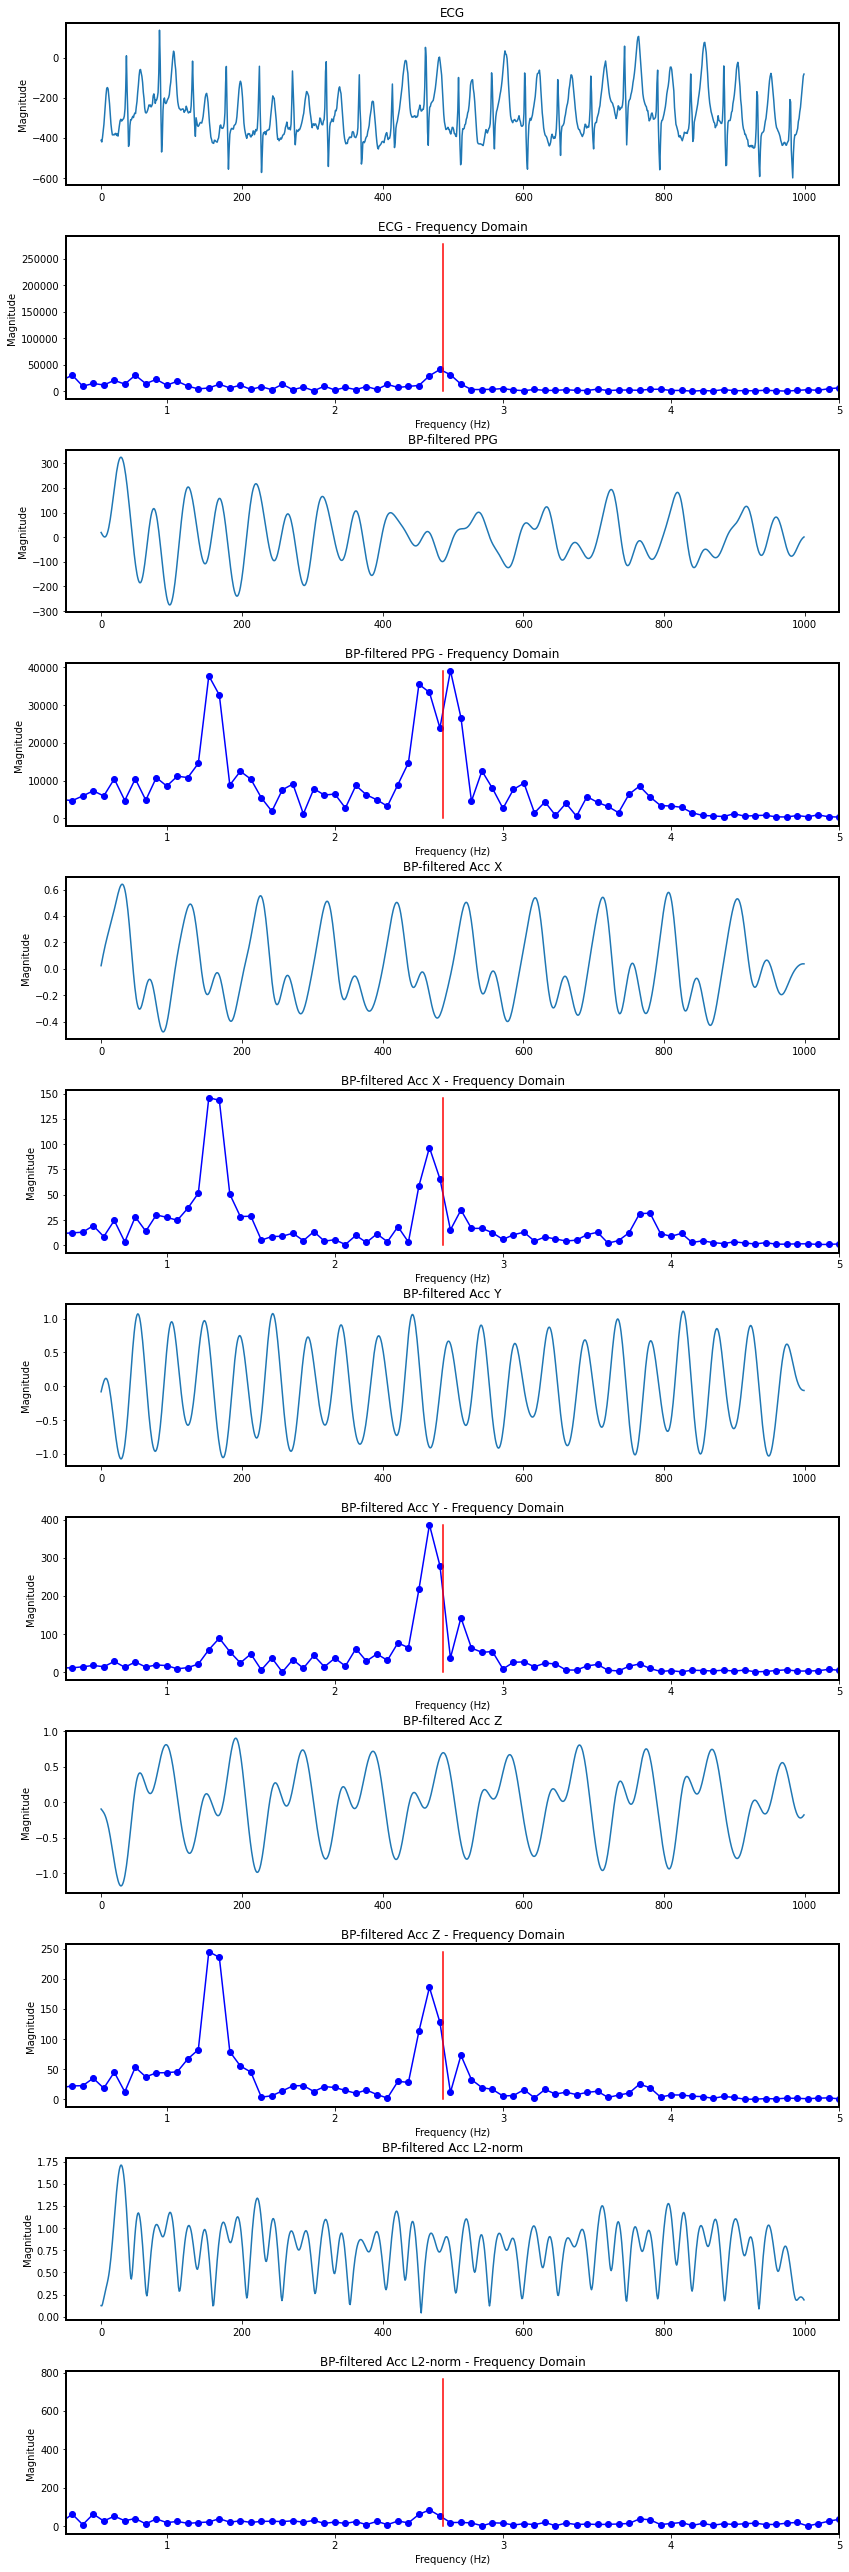

In [7]:
ref_hz = log.ref / 60.0
print("Ground Truth: {} BPM == {} Hz".format(log.ref, ref_hz))
fs = 125
ecg = log.ecg
ppg = log.ppg
ppg_bp = log.ppg_bp
accx = log.accx
accy = log.accy
accz = log.accz
accx_bp = log.accx_bp
accy_bp = log.accy_bp
accz_bp = log.accz_bp

numplots = 12
ax = [None] * numplots
fig, ax = plt.subplots(nrows=numplots, figsize=(12,numplots * 3))
fig.tight_layout(pad=3.0)

plot_time_freq(ax[0], ax[1], ecg, fs, ref_hz, title="ECG")

plot_time_freq(ax[2], ax[3], ppg_bp, fs, ref_hz, title="BP-filtered PPG")


plot_time_freq(ax[4], ax[5], accx_bp, fs, ref_hz, title="BP-filtered Acc X")
plot_time_freq(ax[6], ax[7], accy_bp, fs, ref_hz, title="BP-filtered Acc Y")
plot_time_freq(ax[8], ax[9], accz_bp, fs, ref_hz, title="BP-filtered Acc Z")

acc_l2 = np.sqrt(accx_bp ** 2 + accy_bp ** 2 + accz_bp ** 2)

plot_time_freq(ax[10], ax[11], acc_l2, fs, ref_hz, title="BP-filtered Acc L2-norm")

l2_freqs = np.fft.rfftfreq(len(acc_l2), 1/fs)
l2_fft = np.abs(np.fft.rfft(acc_l2))

fft = fft - l2_fft

fundamental_fs = freqs[np.argmax(fft)]
print("Freq with highest magnitude: {}".format(fundamental_fs))

fs_window = 5 / 60.0
fundamental_fs_window = (freqs >= fundamental_fs - fs_window) & (freqs <= fundamental_fs + fs_window)
conf = np.sum(fft[fundamental_fs_window]) / np.sum(fft)
print("Confidence: {}".format(conf))


# ax[4].plot(sig[2, :])
# ax[5].plot(sig[3, :])
# ax[6].plot(sig[4, :]);

In [ ]:
# One plot at a time
import mpld3
mpld3.enable_notebook()
plt.figure(figsize=(13,6))
plt.plot(ecg)

In [ ]:
sig_ssa = log.sig_ssa
# sig_ssa.plot_wcorr()
# plt.title("W-Correlation for Toy Time Series, $L=20$");

sig_ssa.reconstruct(0).plot()
sig_ssa.reconstruct([1,2,3]).plot()
sig_ssa.reconstruct(slice(4,20)).plot()
sig_ssa.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=400$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);
